## Script Engine Performance Test

Three JS engines were compared using [GraalVM](https://www.graalvm.org/) CE and EE and common Hotspot: Graal JS (for Graal VM only), Rhino and Nashorn. These tests were used: [dromaeo](http://dromaeo.com/?dromaeo) 

Before measure perofrmance 20 warm up iterations were executed to allow JIT make some optimizations. 

**System Configuration**:

OS: Ubuntu 18.04<br>

Processor: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz x 4<br>

RAM: 8 GB

Java: <br>

 - Hotspot VM:<br><br>
`java version "1.8.0_171"
Java(TM) SE Runtime Environment (build 1.8.0_171-b11)
Java HotSpot(TM) 64-Bit Server VM (build 25.171-b11, mixed mode)`
<br><br>

 - GraalVM CE:<br><br>
`openjdk version "1.8.0_212"
OpenJDK Runtime Environment (build 1.8.0_212-20190420092731.buildslave.jdk8u-src-tar--b03)
OpenJDK GraalVM CE 19.0.0 (build 25.212-b03-jvmci-19-b01, mixed mode)`
<br><br>

 - GraalVM EE:<br><br>
`openjdk version "1.8.0_212"
Java(TM) SE Runtime Environment (build 1.8.0_212-b31)
Java HotSpot(TM) GraalVM EE 19.0.0 (build 25.212-b31-jvmci-19-b01, mixed mode)`

In [1]:
# imports
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#input params
results_folder = '../../data'
warmup_subfolder = '/warmup'
result_subfolder = '/results'

warmup_count = 20
warmup_graph_columns = 2

vm_cases = ["graalvm-ce", "graalvm-ee", "common-hotspot"]
engine_cases = {
    "common-hotspot": ["rhino", "nashorn"],
    "graalvm-ce": ["rhino", "nashorn", "graal-js"],
    "graalvm-ee": ["rhino", "nashorn", "graal-js"]
}

In [3]:
data = {vm: {} for vm in vm_cases}


def load_test_res(path):
    res = []
    tests = json.load(open(path))

    for i, test in enumerate(tests):
        local = {
            'name': test['name'],
            'samples': 1 / np.array(test['stats']['sample']),
            'speed_error': test['speed'] * test['stats']['rme'] /
                            100, 'speed': test['speed']
        }
        res.append(local)
    return res


def load_test_results(vm, engine):
    res = [
        load_test_res(
            results_folder + '/' + vm + 
                result_subfolder + '/' + engine + 
                '/results.out'
        )
    ]
    for i in range(0, warmup_count):
        res.append(
            load_test_res(
                '../../data/' + vm + 
                    warmup_subfolder + '/' + engine + 
                    '/results-iter' + str(i) + '.out'
            )
        )
    data[vm][engine] = res

In [4]:
for vm in vm_cases:
    for engine in engine_cases[vm]:
        load_test_results(vm, engine)

In [5]:
def prepare_final_test():
    res = {
        'names': [test['name'] for test in data["common-hotspot"]['nashorn'][0]],
        'graalvm-ce': {},
        'graalvm-ee': {},
        'common-hotspot': {}
    }
    for vm in vm_cases:
        for engine in engine_cases[vm]:
            res[vm][engine + '_values'] = \
                [test['speed'] for test in data[vm][engine][0]]
    
    for vm in vm_cases:
        for engine in engine_cases[vm]:
            res[vm][engine + '_over_rhino_common'] =  \
                np.array(res[vm][engine + '_values']) /\
                    np.array(res['common-hotspot']['rhino_values'])
                      
    return res

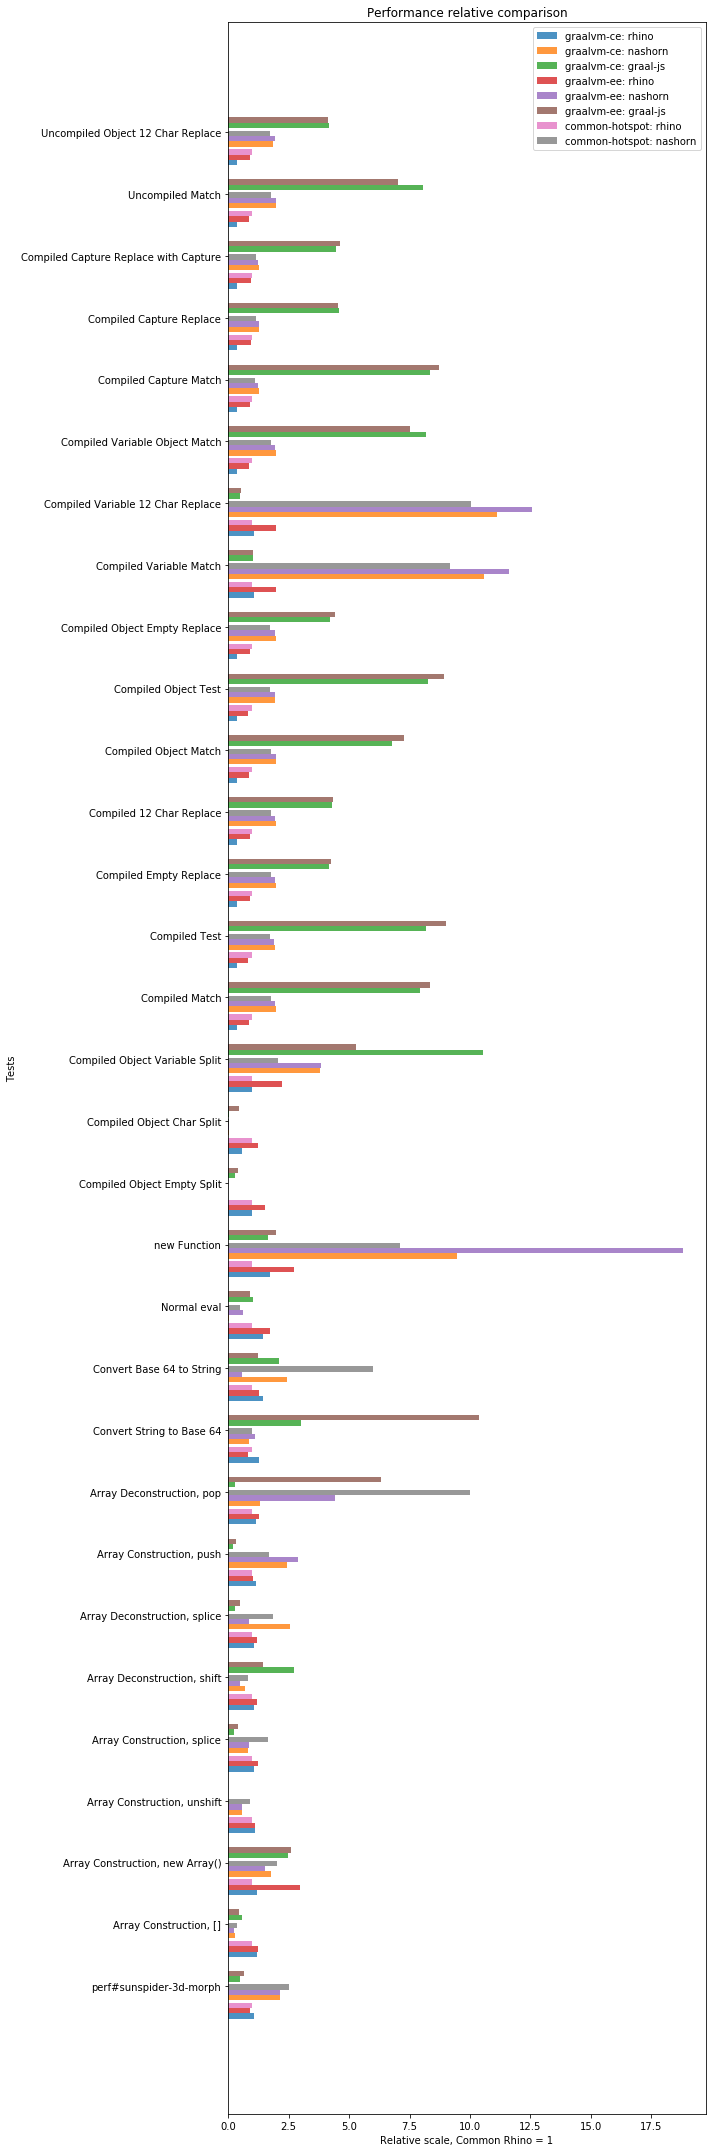

In [6]:
%matplotlib inline
 
final_test_data = prepare_final_test()    
# data to plot
n_groups = len(final_test_data['names'])
 
# create plot
fig, ax = plt.subplots(figsize=(10, 30))
index = np.arange(n_groups)
bar_width = 0.6
opacity = 0.8
bar_width_indent_coef_init = 0
bar_indent_coef = 0

for vm in vm_cases:
    bar_width_indent_coef = bar_width_indent_coef_init
    bar_indent_coef = 0
    
    for engine in engine_cases[vm]:
        plt.barh(
            7 * index + bar_indent_coef + bar_width_indent_coef * bar_width, 
            final_test_data[vm][engine + "_over_rhino_common"], bar_width,
            alpha=opacity, label=vm + ': ' + engine
        )
        bar_width_indent_coef += 2.5
        bar_indent_coef += 0.6
    bar_width_indent_coef_init += 1
 
plt.ylabel('Tests')
plt.xlabel('Relative scale, Common Rhino = 1')
plt.title('Performance relative comparison')
plt.yticks(
    7 * index + (bar_indent_coef + 1) + 2 * bar_width, 
    final_test_data['names']
)
plt.legend()
 
plt.tight_layout()
plt.show()